In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import deeplake
from torchvision import transforms, models, datasets
import flask
from deeplake.core.vectorstore.deeplake_vectorstore import VectorStore
import os
import torch
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image

/Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BDBC688-E93D-38EE-BBB2-E3BEEEAB3977> /Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F37A8933-BE2B-34BD-AE9A-CEE18F73F614> /Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found.

In [69]:
# Load WikiArt
ds = deeplake.load('hub://activeloop/wiki-art')


# Create transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataloader = ds.pytorch(transform=transform, batch_size=32, shuffle=True, tensors=['images', 'labels'])

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wiki-art



/

hub://activeloop/wiki-art loaded successfully.



/Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/deeplake/integrations/pytorch/common.py:137: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


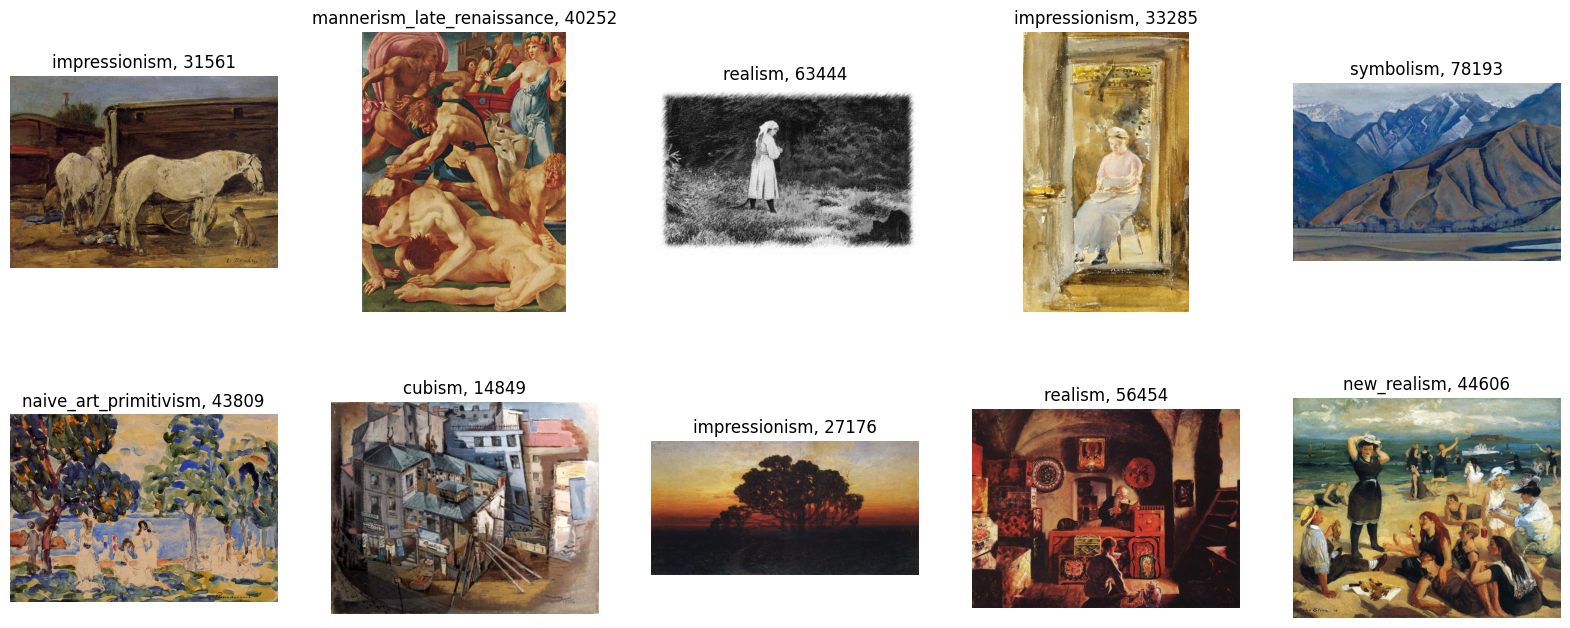

In [3]:
# Show the first 10 images

# Create a grid of images
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

# Get 10 random indices
indices = range(0, len(ds))
indices = np.random.choice(indices, 10, replace=False)
indices = [int(i) for i in indices]

# Plot the images
for i, index in enumerate(indices):
    img = ds.images[index].numpy()
    label = ds.labels[index].data()
    title = label['text'][0]
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_title("{title}, {index}".format(title=title, index=index))
    ax[i // 5, i % 5].axis('off')

In [2]:
# Let's try subject segmentation on 56492
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
import torchvision

# Load the image
img = Image.open('../data/test-images/jordan.jpg')

image_copy = img.copy()
x = torchvision.transforms.functional.to_tensor(img)

# From https://pytorch.org/vision/stable/models.html#semantic-segmentation
# Load weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights, pretrained=True)

# Set the model to evaluation mode
preprocess = weights.transforms()

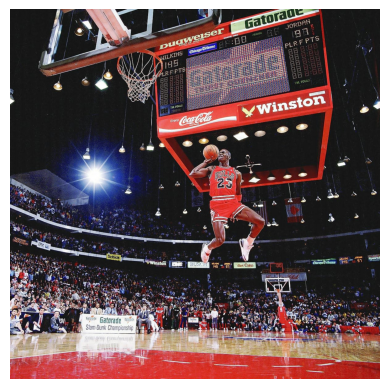

In [3]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
batch = preprocess(x).unsqueeze(0)

# Perform inference
prediction = model(batch)['out']
normalized_masks = prediction.softmax(dim=1)

/Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/var/folders/hg/dd3yfd8j7vx8qtmvm42400j80000gn/T/ipykernel_37341/2966475622.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  numpy_mask = torch.tensor(mask).numpy()


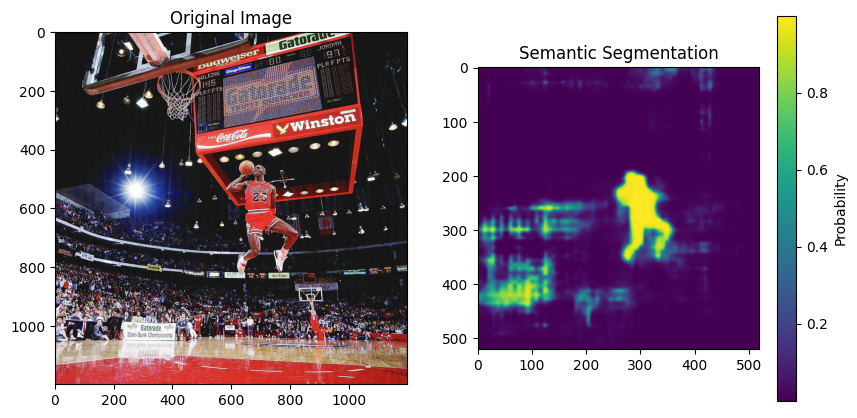

In [5]:
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["person"]]
pil_semantic = to_pil_image(mask)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x.permute(1, 2, 0))
ax[1].imshow(pil_semantic)

# Add titles
ax[0].set_title('Original Image')
ax[1].set_title('Semantic Segmentation')

# Add colorbar
numpy_mask = torch.tensor(mask).numpy()
cbar = plt.colorbar(ax[1].imshow(numpy_mask, cmap='viridis'), ax=ax[1])
cbar.set_label('Probability')
plt.show()

/Users/Austin/opt/anaconda3/envs/dsan6600/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


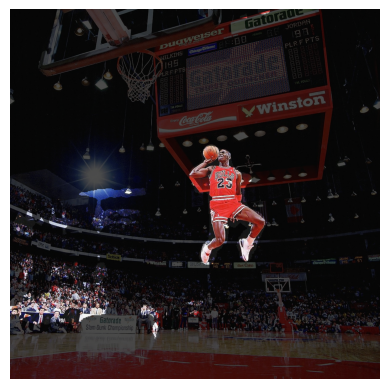

In [76]:
# Function that takes in an image and returns the dimmed image
def person_highlighter(image_path, threshold=0.5, dimming_factor=0.3):
    img = Image.open(image_path)
    image_copy = img.copy()
    x = torchvision.transforms.functional.to_tensor(img)

    # Load weights
    weights = FCN_ResNet50_Weights.DEFAULT
    model = fcn_resnet50(weights=weights, pretrained=True)

    # Set the model to evaluation mode
    preprocess = weights.transforms()

    batch = preprocess(x).unsqueeze(0)

    # Perform inference
    prediction = model(batch)['out']
    normalized_masks = prediction.softmax(dim=1)

    class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
    mask = normalized_masks[0, class_to_idx["person"]]

    # Add zeroes to the mask so it's the same size as the image
    mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(img.height, img.width), mode='nearest').squeeze(0).squeeze(0)

    person_mask = mask > threshold

    dimmed_img = image_copy.copy()
    
    # Make dimmed img the same size as the person mask
    dimmed_img = np.array(img)

    # Multiply the dimmed image by the mask

    # This is much faster but struggles with certain sized photos

    ### TODO: Make this work with any size photo by adding 0 padding to the mask
    try:
        dimmed_img[~person_mask] = dimmed_img[~person_mask] * dimming_factor
        
    except IndexError:

        for y in range(img.size[1]):
            for x in range(img.size[0]):
                if not person_mask[y, x]:
                    dimmed_img[y, x] = dimmed_img[y, x] * dimming_factor

    return Image.fromarray(dimmed_img)


# Test the function
dimmed_img = person_highlighter('../data/test-images/jordan.jpg', threshold=0.4, dimming_factor=0.3)
plt.imshow(dimmed_img)
plt.axis('off')
plt.show()

## Applied to test photos

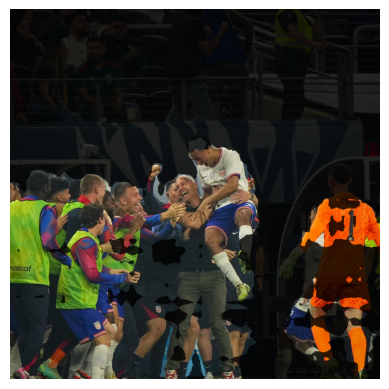

In [58]:
dimmed_img = person_highlighter('../data/test-images/tyler_adams.jpg', threshold=0.2, dimming_factor=0.2)
plt.imshow(dimmed_img)
plt.axis('off')
plt.show()

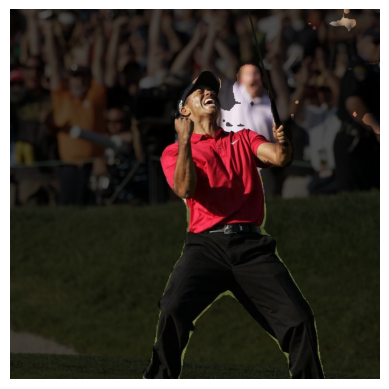

In [59]:
dimmed_img = person_highlighter('../data/test-images/tiger.jpg', threshold=0.5, dimming_factor=0.3)
plt.imshow(dimmed_img)
plt.axis('off')
plt.show()

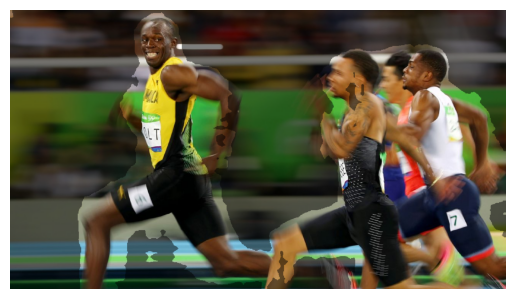

In [67]:
dimmed_img = person_highlighter('../data/test-images/bolt.jpg', threshold=0.01, dimming_factor=0.5)
plt.imshow(dimmed_img)
plt.axis('off')
plt.show()

## Applied to art

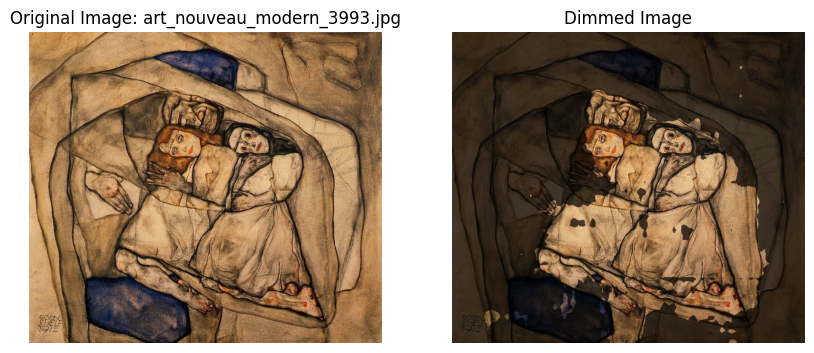

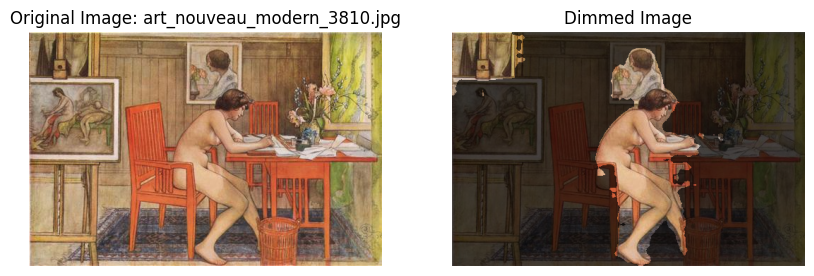

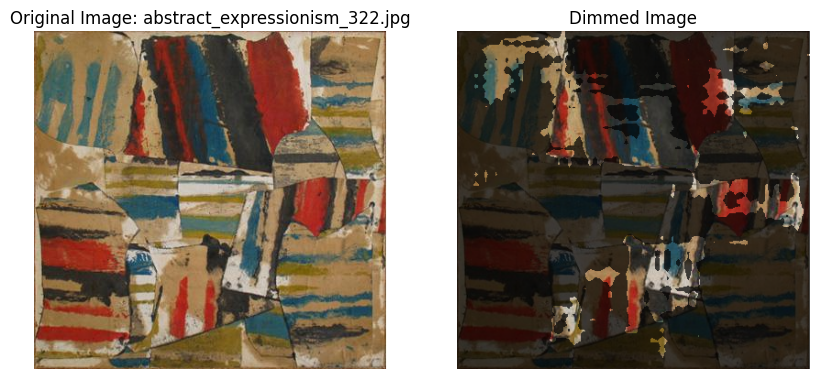

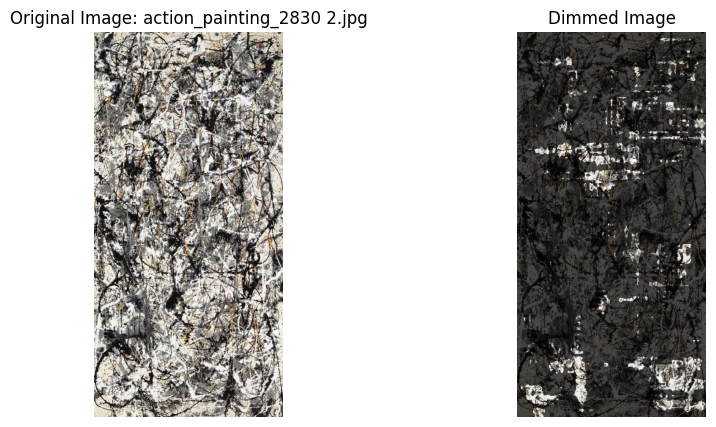

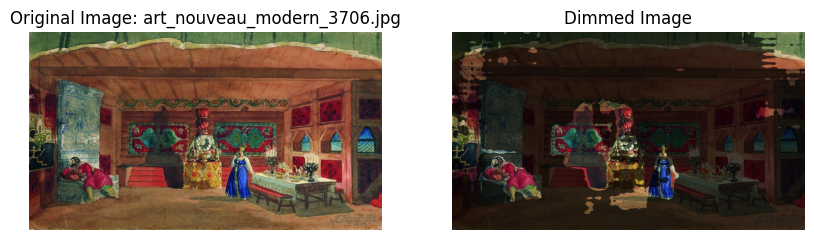

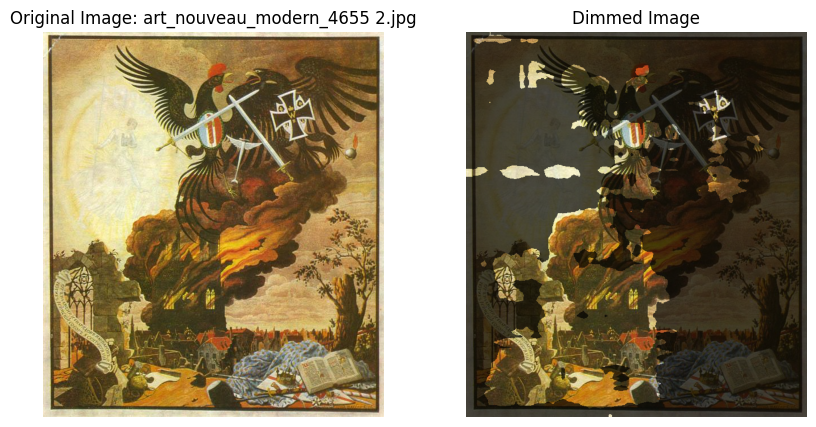

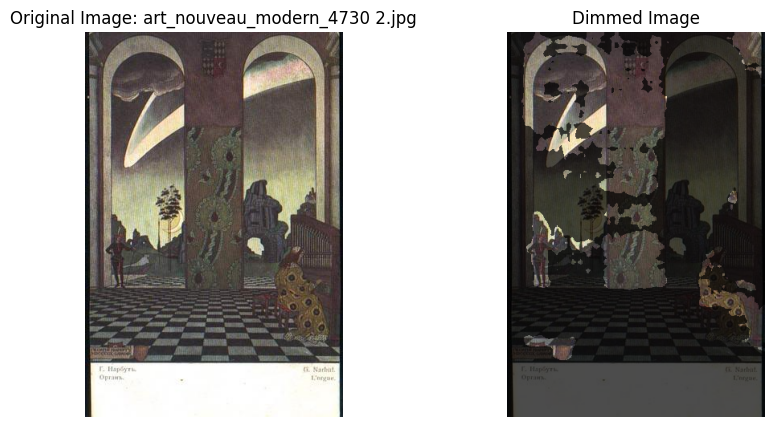

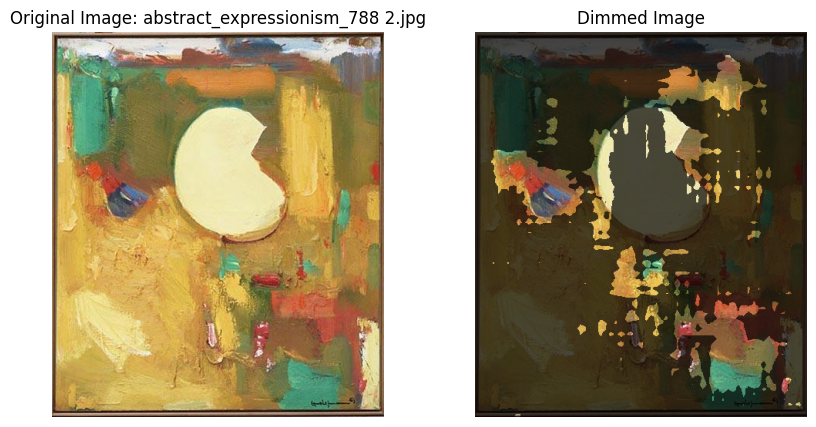

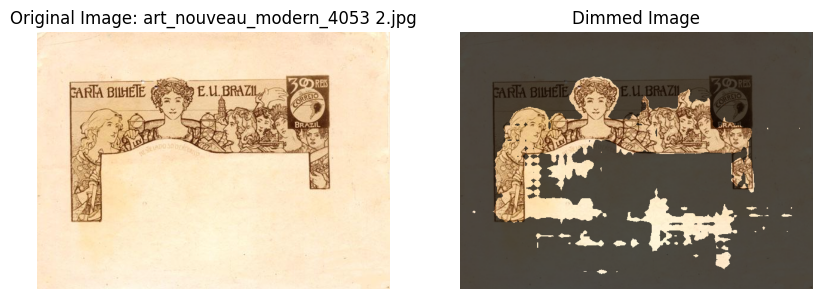

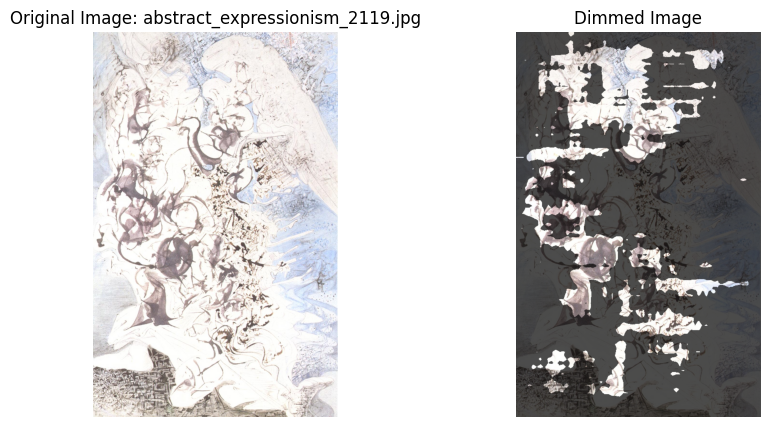

In [80]:
# Pick 10 random images from the images folder
images_fn = os.listdir('./images/')
images_10 = np.random.choice(images_fn, 10, replace=False)

# Add the path to the images
images_10 = ['./images/' + i for i in images_10]


# Plot the images
for i, path in enumerate(images_10):
    img = Image.open(path)
    dimmed_img = person_highlighter(path, threshold=0.1, dimming_factor=0.3) # Art is more abstract, so we need to lower the threshold
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(dimmed_img)
    ax[0].axis('off')
    ax[1].axis('off')
    image_name = path.split('/')[-1]
    ax[0].set_title('Original Image: ' + image_name)
    ax[1].set_title('Dimmed Image')
    plt.show()

# TODO:
- [ ] Apply to test and art photos
- [ ] Try ResNet34 on the segmented photos and compare the results to the original photos
